In [1656]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [1657]:
# GENERAL MACHINE LEARNING FUNCTIONS
def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=0)

def compute_loss(y, p):

    return -np.sum(np.log(np.sum(y * p, axis=0)))

def adagrad(m_old, g, param_old, eta):
    m = m_old + np.power(g, 2)
    param = param_old - (eta / np.sqrt(m + np.finfo('float').eps)) * g

    return param, m

In [1658]:
# HELPER FUNCTIONS
def read():
  with open("goblet_book.txt") as file:
      text = file.read()
  return text

def one_hot(vec, conversor):
    mat = np.zeros((len(conversor), len(vec)))
    for i in range(len(vec)):
        mat[conversor[vec[i]], i] = 1

    return mat
  
def synthesize(rnn, h_0, x_0, n):
    print(h_0.shape)
    print(x_0.shape)
    x = np.copy(x_0)
    h = np.copy(h_0)[:, np.newaxis]
    samples = np.zeros((x_0.shape[0], n))
    for t in range(n):
        a = rnn.w @ h + rnn.u @ x + rnn.b
        h = np.tanh(a)
        o = rnn.v @ h + rnn.c
        p = softmax(o)
        choice = np.random.choice(range(x.shape[0]), 1, p=p.flatten())  # Select random character
        # according to probabilities
        x = np.zeros(x.shape)
        x[choice] = 1
        samples[:, t] = x.flatten()

    return samples

In [1659]:
# RNN SPECIFIC FUNCTIONS
def forward(rnn, h_0, x):
    h = np.zeros((h_0.shape[0], x.shape[1]))
    a = np.zeros((h_0.shape[0], x.shape[1]))
    prob = np.zeros(x.shape)
    
    for t in range(x.shape[1]):
        if t == 0:
            a[:, t] = (rnn.w @ h_0[:, np.newaxis] + rnn.u @ x[:, t][:, np.newaxis] + rnn.b).flatten()
        else:
            a[:, t] = (rnn.w @ h[:, t - 1][:, np.newaxis] + rnn.u @ x[:, t][:, np.newaxis] + rnn.b).flatten()
            
        h[:, t] = np.tanh(a[:, t])
        
        o = rnn.v @ h[:, t][:, np.newaxis] + rnn.c
        p = softmax(o)
        prob[:, t] = p.flatten()

    return prob, h, a

def backprop(rnn, y, p, h, h_prev, a, x):
    grad_h = list()
    grad_a = list()
    # Computation of the last gradient of o
    grad_o = -(y - p).T
    # Computation of the last gradients of h and a
    grad_h.append(grad_o[-1][np.newaxis, :] @ rnn.v)
    grad_a.append((grad_h[-1] @ np.diag(1 - np.power(np.tanh(a[:, -1]), 2))))
    # Computation of the remaining gradients of o, h, and a
    for t in reversed(range(y.shape[1] - 1)):
        grad_h.append(grad_o[t][np.newaxis, :] @ rnn.v + grad_a[-1] @ rnn.w)
        grad_a.append(grad_h[-1] @ np.diag(1 - np.power(np.tanh(a[:, t]), 2)))

    grad_a.reverse()  # Reverse a gradient so it goes forwards
    grad_a = np.vstack(grad_a)  # Stack gradients of a as a matrix
    rnn_grads = copy.deepcopy(rnn)  # Define rnn object to store the gradients
    rnn_grads.v = grad_o.T @ h.T
    h_aux = np.zeros(h.shape)  # Auxiliar h matrix that includes h_prev
    h_aux[:, 0] = h_prev
    h_aux[:, 1:] = h[:, 0:-1]
    
    rnn_grads.w = grad_a.T @ h_aux.T
    rnn_grads.u = grad_a.T @ x.T
    rnn_grads.b = np.sum(grad_a, axis=0)[:, np.newaxis]
    rnn_grads.c = np.sum(grad_o, axis=0)[:, np.newaxis]
    
    return rnn_grads

In [1660]:
# GRADIENTS
import numpy as np
import copy
from tqdm import tqdm

def computeGrads(rnn, x, y, h, grads):
    res_rnn = copy.deepcopy(rnn)
    h_prev = np.zeros(rnn.m)
    for idx, att in enumerate(['b', 'c', 'u', 'w', 'v']):
        grad = np.zeros(getattr(rnn, att).shape)
        for i in range(grad.shape[0]):
            for j in range(grad.shape[1]):
                rnn_try = copy.deepcopy(rnn)
                aux = np.copy(getattr(rnn_try, att))
                aux[i, j] -= h
                setattr(rnn_try, att, aux)
                p = forward(rnn_try, h_prev, x)[0]
                l1 = compute_loss(y, p)
                rnn_try = copy.deepcopy(rnn)
                aux = np.copy(getattr(rnn_try, att))
                aux[i, j] += h
                setattr(rnn_try, att, aux)
                p = forward(rnn_try, h_prev, x)[0]
                l2 = compute_loss(y, p)
                grad[i, j] = (l2 - l1) / (2 * h)
        setattr(res_rnn, att, grad)

    # print('b')
    # print(grads.b)
    # print('c')
    # print(grads.c)
    print('b', np.mean(abs(grads.b - res_rnn.b)))
    print('c', np.mean(abs(grads.c - res_rnn.c)))
    print('u', np.mean(abs(grads.u - res_rnn.u)))
    print('v', np.mean(abs(grads.v - res_rnn.v)))
    print('w', np.mean(abs(grads.w - res_rnn.w)))

In [1661]:
def initialize():
    text = read()
    # text = text.lower()
    # text = text.replace("\n", " ")
    indexToToken = {}
    n = 0
    for letter in text:
        if letter not in indexToToken.values():
          indexToToken[n] = letter
          n+=1

    tokenToIndex = {v: k for k, v in indexToToken.items()}

    m = 5
    eta = 0.1
    seq_length = 25
    K = len(indexToToken)
    sig = 0.01

    b = np.zeros((m, 1))
    c = np.zeros((K, 1))
    U = np.random.rand(m, K)*sig
    W = np.random.rand(m, m)*sig
    V = np.random.rand(K, m)*sig

    return indexToToken, tokenToIndex, m, eta, seq_length, K, b, c, U, W, V, text

In [1662]:
class Gradients:
  def __init__(self, b, c, U, W, V):
    self.b = b
    self.c = c
    self.U = U
    self.W = W
    self.V = V


def charToVec(index, k):
  vec = np.zeros(k)
  vec[index] = 1
  return vec

def charSeqToVecSeq(charSeq, tokenToIndex, K):
  veqSeq = np.zeros((K, len(charSeq)))
  for col, char in enumerate(charSeq):
    row = tokenToIndex.get(char.lower())
    veqSeq[row,col] = 1
  return veqSeq

def softMax(o_t):
  """ Standard definition of the softmax function """
  return np.exp(o_t) / np.sum(np.exp(o_t), axis=0)

def tanh(a_t):
  return np.tanh(a_t) # This was an in build function? Really? So much time wasted.

class RNN():
  def __init__(self):
    self.indexToToken, self.tokenToIndex, self.m, self.eta, self.seq_length, self.k, self.b, self.c, self.u, self.w, self.v, self.chars = initialize()
    self.h_history, self.a_history, self.o_history, self.p_history, self.loss_history, self.y_history, h_prev_0 = [], [], [], [], [], [], []
    self.smoothLossValue = None
    
  def getFullStop(self):
    return charToVec(self.tokenToIndex.get("."), self.k)
  
  def charSeqToVecSeq(self, charSeq):
    return charSeqToVecSeq(charSeq, self.tokenToIndex, self.k)
  
  
  def forward(self, X, h0, Y):
    if h0 is None:
      h0 = np.zeros((self.m))
    h_prev = h0
    
    self.h_prev_0 = h_prev
    h_history = []
    a_history = []
    p_history = []
    y_history = []

    # Korrekt hittils
    # Transpose X to step through the columns
    index = 0
    for x_t in X.T:
      y_t = Y.T[index]
      a_t = np.dot(self.w, h_prev[:, np.newaxis]) + np.dot(self.u, x_t[:, np.newaxis]) + self.b # Yay
      h_t = tanh(a_t) # Yay
      
      o_t = np.dot(self.v, h_t) + self.c # Yay (?)
      p_t = softMax(o_t) # Yay
      # loss = self.calcLoss(y_t, p_t) # Todo: save loss history

      h_history.append(h_t.flatten())
      a_history.append(a_t.flatten())
      p_history.append(p_t.flatten())
      y_history.append(y_t.flatten())
      
      h_prev = h_t.flatten()
      index += 1
    
    self.h_history, self.a_history, self.p_history, self.y_history = h_history, a_history, p_history, y_history # Overwrite and save for backpropagation
    # self.loss_history.append(self.smoothLoss(loss))
    
    return np.array(p_history).T, np.array(h_history).T, np.array(a_history).T #, loss
  
  def calcLoss(self, y_t, p_t): # (BAD)! This is not the loss function
    # Calculate the cross entropy loss
    loss = -np.sum(np.dot(y_t, np.log(p_t)))
    return loss
  
  def gethHistory(self):
    h_history_h0 = self.h_history.copy()
    for index, h in enumerate(self.h_history):
      if index == 0:
        h_history_h0[index] = self.h_prev_0
      else:
        h_history_h0[index] = self.h_history[index-1]
    
    return h_history_h0
  
  def backprop(self, y, p, h, h_prev, a, x):
    gradW, gradV, gradU = np.zeros(self.w.shape), np.zeros(self.v.shape), np.zeros(self.u.shape)
    gradb, gradc = np.zeros(self.b.shape), np.zeros(self.c.shape)

    # Claculate all dLdo's
    dlDos = np.zeros((self.seq_length, self.k))
    dlDas = np.zeros((self.seq_length, self.m))
    dlDhs = np.zeros((self.seq_length, self.m))
    index = 0
    for y_t, p_t in zip(self.y_history, self.p_history):
      dLdo_t = -(y_t - p_t) # Yay
      dlDos[index] = dLdo_t
      index += 1
      
    # Init dLda t+1
    dLdh_t = np.dot(dlDos[-1][np.newaxis, :],self.v) # Last dLdo
    dLda_t1 = (dLdh_t.flatten() @ np.diag(1 - np.power(tanh(self.a_history[-1]), 2))) # The last dLDa
    
    dLdh_t2 = dlDos[-1][np.newaxis, :] @ self.v # !
    dLda_t2 = (dLdh_t2[-1] @ np.diag(1 - np.power(np.tanh(a[:, -1]), 2))) # !
    
    dlDas[-1] = dLda_t1
    index = len(self.y_history) - 2
    for _ in range(len(self.y_history)-1):
      dLdo_t = dlDos[index][np.newaxis, :]
      dLdh_t = np.dot(dLdo_t, self.v) + np.dot(dLda_t1, self.w) # Yay?
      dLda_t = dLdh_t.flatten() @ np.diag(1 - np.power(tanh(self.a_history[index]), 2))
      dlDas[index] = dLda_t
      index -= 1
      dLda_t1 = dLda_t

    gradW, gradV, gradU, gradb, gradc = np.zeros(self.w.shape), np.zeros(self.v.shape), np.zeros(self.u.shape), np.zeros(self.b.shape), np.zeros(self.c.shape)
    
    h_history_h0 = self.gethHistory() 
    gradU = np.dot(dlDas.T, x.T)
    gradW = np.dot(dlDas.T, h_history_h0)
    for t in range(len(self.y_history)):
      gradV += np.dot(dlDos[t].reshape(dlDos[t].shape[0], 1), self.h_history[t].reshape(1, self.h_history[t].shape[0]))
      gradb += dlDas[t][:,np.newaxis]
      gradc += dlDos[t][:,np.newaxis]
    
    #### !!!
    rnn_grads = copy.deepcopy(self)  # Define rnn object to store the gradients
    rnn_grads.v = gradV #dlDos.T @ h.T   
    rnn_grads.w = gradW  # h_history contains the h0 starting state
    rnn_grads.u = gradU
    rnn_grads.b = gradb 
    rnn_grads.c = gradc
    #### !!!
    return rnn_grads
    return Gradients(np.clip(gradb, -5, 5), np.clip(gradc, -5, 5), np.clip(gradU, -5, 5), np.clip(gradW, -5, 5), np.clip(gradV, -5, 5))  
  
  def backprop2(self, x_history):
    gradW, gradV, gradU = np.zeros(self.W.shape), np.zeros(self.V.shape), np.zeros(self.U.shape)
    gradb, gradc = np.zeros(self.b.shape), np.zeros(self.c.shape)

    # Claculate all dLdo's
    dlDos = np.zeros((self.seq_length, self.K))
    dlDas = np.zeros((self.seq_length, self.m))
    index = 0
    for y_t, p_t in zip(self.y_history, self.p_history):
      dLdo_t = -(y_t - p_t) # Yay
      dlDos[index] = dLdo_t
      index += 1
      
    # Init dLda t+1
    dLdh_t = np.dot(self.V.T, dlDos[-1]) # Last dLdo
    dLda_t1 = dLdh_t @ np.diag(1 - np.power(tanh(self.a_history[-1]), 2)) # The last dLDa

    index = len(self.y_history) - 1
    for _ in range(len(self.y_history)):
      dLdo_t = dlDos[index]
      dLdh_t = np.dot(self.V.T, dLdo_t) + np.dot(self.W.T, dLda_t1) # Yay?
      dLda_t = dLdh_t @ np.diag(1 - np.power(tanh(self.a_history[index]), 2))
      dlDas[index] = dLda_t
      index -= 1
      dLda_t1 = dLda_t
    
    # Compute the gradient loss with respect to W, V, U, b and c
    gradW, gradV, gradU, gradb, gradc = np.zeros(self.W.shape), np.zeros(self.V.shape), np.zeros(self.U.shape), np.zeros(self.b.shape), np.zeros(self.c.shape)
    
    h_history_h0 = self.h_history.copy()
    for index, h in enumerate(self.h_history):
      h_history_h0[index] = h_history_h0[index-1] if index > 0 else self.h_prev_0 
    
    for t in range(len(self.y_history)):
      gradV += np.dot(dlDos[t].reshape(dlDos[t].shape[0], 1), self.h_history[t].reshape(1, self.h_history[t].shape[0])) # Yay?
      gradW += np.dot(dlDas[t], h_history_h0[t]) # h_history contains the h0 starting state
      # gradU += np.dot(dlDas.T[t], x_history[t]) # Yay ?
      gradb += dlDas[t] # Yay ?
      gradc += dlDos[t] # Yay ?
    print(gradW)
    return Gradients(np.clip(gradb, -5, 5), np.clip(gradc, -5, 5), np.clip(gradU, -5, 5), np.clip(gradW, -5, 5), np.clip(gradV, -5, 5))

b 7.19677836422128e-11
c 4.845387812532731e-10
u 6.973242597294141e-12
v 4.611576485133264e-11
w 3.7468503537709064e-11


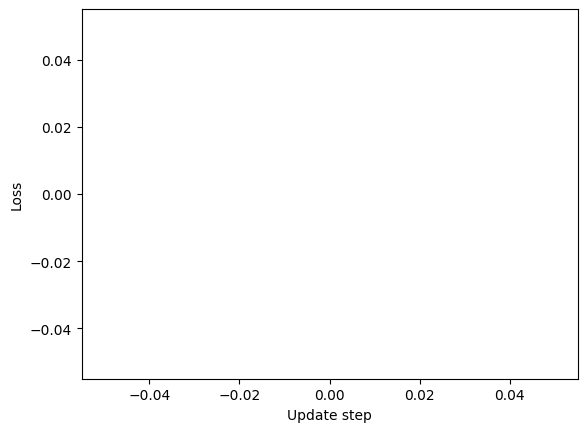

AttributeError: 'NoneType' object has no attribute 'getFullStop'

In [1663]:
# MAIN ALGORITHM
def main():
    np.random.seed(101)
    rnn = RNN()  # Initialize recurrent neural network object, m=m, eta=eta, seq_length=seq_length, sig=0.01
    e = 0  # Pointer in the book
    h_prev = np.zeros(rnn.m)  # First hidden state
    loss_list = list()
    smooth_loss = 0
    m_list = [0, 0, 0, 0, 0]
    best_rnn = None
    best_loss = float('inf')
    stop = False
    
    nIter = int(len(rnn.chars)/25)
    for i in range(nIter):
        x_chars = rnn.chars[i*25:(i+1)*25]
        y_chars = rnn.chars[i*25+1:(i+1)*25+1]
        x = rnn.charSeqToVecSeq(x_chars)
        y = rnn.charSeqToVecSeq(y_chars)
        
        p, h, a = rnn.forward(x, h_prev, y)
        rnn_grads = rnn.backprop(y, p, h, h_prev, a, x)
        
        computeGrads(rnn, x, y, 1e-4, rnn_grads)
        stop = True
        if stop:
            break
        # Check exploding gradients
        for idx, att in enumerate(['b', 'c', 'u', 'w', 'v']):
            grad = getattr(rnn_grads, att)
            grad = np.clip(grad, -5, 5)
            att_new, m_val = adagrad(m_list[idx], grad, getattr(rnn, att), rnn.eta)
            setattr(rnn, att, att_new)
            m_list[idx] = m_val
        if i == 0:
            smooth_loss = compute_loss(y, p)
            loss_list.append(smooth_loss)
            best_rnn = copy.deepcopy(rnn)  # Select first model as the best one
            best_loss = smooth_loss  # Update best loss with the new one
        else:
            smooth_loss = 0.999 * smooth_loss + 0.001 * compute_loss(y, p)
            if smooth_loss < best_loss:  # Check model loss
                best_rnn = copy.deepcopy(rnn)  # Update best model
                best_loss = smooth_loss  # Update best loss
            if i*25 % (rnn.seq_length * 100) == 0:
                print(smooth_loss)
                loss_list.append(smooth_loss)
        h_prev = h[:, -1]  # h_prev updated to the last computed hidden state
        e += rnn.seq_length  # Update the pointer
    e = 0  # Reset e when there are no enough characters
    h_prev = np.zeros(h_prev.shape)  # Reset h_prev to 0

    
    plt.plot(np.arange(len(loss_list)) * 100, loss_list)
    plt.xlabel("Update step")
    plt.ylabel("Loss")
    plt.show()
    x_0 = best_rnn.getFullStop()
    # x_0 = one_hot('.', char_to_ind)
    print("Lowest loss: " + str(best_loss))
    h_prev = np.zeros(rnn.m)
    samples = synthesize(best_rnn, h_prev, x_0, 1000) #synthesize(best_rnn, h_prev, x_0, 1000)
    samples = [best_rnn.indexToToken[int(np.argmax(samples[:, n]))] for n in range(samples.shape[1])]
    print("\n")
    print("".join(samples))
    print("\n")

def synthesize(rnn, h0, x0, n):
    h_prev, x_prev = h0, x0
    Y = np.zeros((n, rnn.k)) # Matrix of One-hot vectors of length n representing letters 
    for i in range(n):
      a_t = np.dot(rnn.w, h_prev)
      a_t += np.dot(rnn.u, x_prev) 
      a_t += rnn.b
      h_t = np.tanh(a_t)
      o_t = np.dot(rnn.v, h_t) + rnn.c
      p_t = softMax(o_t)

      h_prev = h_t
      x_prev = rnn.genNextX(p_t)
      Y[i] = x_prev

    return rnn.matrixOfOneHotToChars(Y)
    

main()